In [1]:
import cv2

import numpy as np
import matplotlib.pyplot as plt

In [45]:
def t_test(X_bar, mean, variance, n):
    '''
    t检验
    :param X_bar: 样本均值
    :param mean: 总体均值
    :param variance: 样本方差
    :param n: 样本大小
    :return: t统计量
    '''
    # 双边t检验的公式:
    # t = (x̄ - μ) / (s / √n)
    # 其中 x̄ 是样本均值, μ 是总体均值, s 是样本标准差, n 是样本大小

    t_statistic = (X_bar - mean) / (variance / (n ** 0.5))

    return t_statistic

def threshold(X_bar, standard_X, mean, var, n):
    '''
    阈值法检测异常帧
    :param X_bar: 样本均值
    :param standard_X: 标准对照值（按照顺序依次取 n-20 )
    :param mean: 总体均值
    :param var: 总体方差
    :param n: 样本大小
    '''
    # 公式 first_X - mean
    # 公式 (first_X - X_bar) + (X_bar - mean)
    # 拆分为threshold1 和 threshold2
    # 其中 threshold1 = first_X - X_bar 表示当前帧与第一帧的差值
    # 其中 threshold2 = X_bar - mean 表示当前帧与均值的差值
    # threshold1 表示为与标准差的波动表示为像素级别的波动，这里的 threshold1 可以取固定值 

    threshold1 = abs(X_bar - standard_X)
    threshold2 = abs(X_bar - mean)
    # 当 threshold1 > 10 , 则认为是异常像素点
    outliers1 = (threshold1 > 10)  
    # 但是，由于视频的每一帧都伴随有光线的变化，所以 threshold2 也会有波动，所以 threshold2 也需要设置一个阈值
    # threshold2 是由于两个均值之间的误差，这里使用t检验
    # z = (x̄ - μ) / (s / √n)
    # 这里的 alpha 取 0.05， z_alpha/0.025 = 1.96
    # 当 z > 1.96 时，认为是异常像素点
    outliers2 = (t_test(X_bar, mean, var, n) > 1.96)

    outliers = outliers1 * outliers2
    return threshold1,outliers2,outliers

In [43]:
def detect_connected_components(image, min_area=80, top_n=2):
    """
    对单张二值图像进行联通区域检测，保留最大的top_n个区域，并标注区域边界和质心。

    参数：
        image: 输入的二值图像（黑白掩码，dtype=np.uint8）。
        min_area: 过滤掉小于此面积的区域。
        top_n: 保留最大的top_n个区域。

    返回：
        output_image: 标注区域边界和质心的彩色图像。
        stats: 每个区域的统计信息 [x, y, width, height, area]。
        centroids: 每个区域的质心坐标。
        largest_regions: 最大的top_n个区域的二值化图像。
    """
    # 检测联通区域
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    
    # 将输入图像转为彩色，便于绘制标注
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # 创建一个空的二值图像，用于保存最大的top_n个区域
    largest_regions = np.zeros_like(image)

    # 存储每个区域的面积及其标签
    areas = []
    for label in range(1, num_labels):
        area = stats[label, cv2.CC_STAT_AREA]
        if area >= min_area:
            areas.append((label, area))

    # 根据面积排序，选择最大的top_n个区域
    areas = sorted(areas, key=lambda x: x[1], reverse=True)[:top_n]

    # 遍历保留的区域
    for label, area in areas:
        # 提取区域统计信息
        x, y, w, h, _ = stats[label]
        cx, cy = centroids[label]

        # 将该区域添加到largest_regions图像中
        largest_regions[labels == label] = 255

        # 绘制边界框
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # 绘制质心
        cv2.circle(output_image, (int(cx), int(cy)), 5, (0, 0, 255), -1)

        # 在区域旁标注索引
        cv2.putText(output_image, f"ID: {label}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    return largest_regions

/tmp/ipykernel_918878/3309348251.py:14: RuntimeWarning: divide by zero encountered in divide
  t_statistic = (X_bar - mean) / (variance / (n ** 0.5))
/tmp/ipykernel_918878/3309348251.py:14: RuntimeWarning: invalid value encountered in divide
  t_statistic = (X_bar - mean) / (variance / (n ** 0.5))


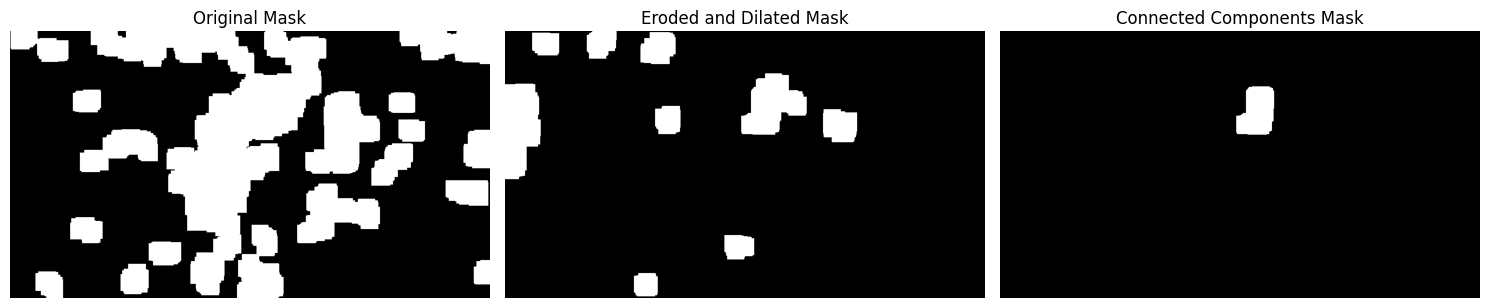

In [72]:
X_bar = cv2.imread('/home/byh/Tears-illusion-/data/output/frame/00000.jpg', cv2.IMREAD_GRAYSCALE)
standard_X = cv2.imread('/home/byh/Tears-illusion-/data/output/frame/00050.jpg', cv2.IMREAD_GRAYSCALE)
mean = cv2.imread('/home/byh/Tears-illusion-/data/output/statistics/mean_image.png', cv2.IMREAD_GRAYSCALE)
var = cv2.imread('/home/byh/Tears-illusion-/data/output/statistics/variance_image.png', cv2.IMREAD_GRAYSCALE)

n = 133
mask1, mask2, mask = threshold(X_bar, standard_X, mean, var, n)

# 将布尔mask转换为uint8类型，True为255，False为0
mask_uint8 = mask.astype(np.uint8) * 255
kernel = np.ones((5, 5), np.uint8) 
outliersa = np.array(mask_uint8, dtype=np.uint8) * 255
mask_uint8 = cv2.erode(outliersa, kernel=kernel, iterations=1)  # 腐蚀
mask_uint8 = detect_connected_components(mask_uint8,125,100)
mask_uint8 = cv2.dilate(np.array(mask_uint8, dtype=np.uint8) * 255, np.ones((11, 11), np.uint8) , iterations=3)

# 将布尔mask1转换为uint8类型，True为255，False为0
mask_1 = mask1.astype(np.uint8) * 255
kernel = np.ones((5, 5), np.uint8) 
outliersa = np.array(mask1, dtype=np.uint8) * 255
mask1 = cv2.erode(outliersa, kernel=kernel, iterations=1)  # 腐蚀
mask1 = detect_connected_components(mask1,80,100)
mask1 = cv2.dilate(np.array(mask1, dtype=np.uint8) * 255, np.ones((11, 11), np.uint8) , iterations=3)

# 将布尔mask2转换为uint8类型，True为255，False为0
mask2 = mask2.astype(np.uint8) * 255
kernel = np.ones((5, 5), np.uint8) 
outliersa = np.array(mask2, dtype=np.uint8) * 255
mask2 = cv2.erode(outliersa, kernel=kernel, iterations=1)  # 腐蚀
mask2 = detect_connected_components(mask2,80,100)
mask2 = cv2.dilate(np.array(mask2, dtype=np.uint8) * 255, np.ones((11, 11), np.uint8) , iterations=3)
# 使用 matplotlib 显示图像
# 使用 matplotlib 显示图像
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 显示原始 mask
ax[0].imshow(mask1, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original Mask')

# 显示腐蚀后的 mask
ax[1].imshow(mask2, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Eroded and Dilated Mask')

# 显示连通组件检测后的 mask
ax[2].imshow(mask_uint8, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Connected Components Mask')

plt.tight_layout()
plt.show()